# Correlation btw indices time series

Determine optimized spectral index for Svamängar detection. 

Author: Morgane Magnier (morgane.magnier@vattenfall.com)

Copyright © 2024 Magnier Morgane 

This notebook is part of a thesis project. The copyright of the thesis itself belongs to the student Morgane Magnier.  

**Rights and Intellectual Property**:  
- Vattenfall has the right to use the findings, methods, and conclusions of this thesis in its operations.  
- Any material generated within the framework of this thesis that is subject to intellectual property protection (e.g., source code, computer program, design, or invention) belongs to Vattenfall, unless otherwise agreed in writing.  

Permission is granted to view, copy, and share this notebook for **educational or personal purposes only**, provided that this notice is included in all copies.  

---

In [ ]:
import ee, eemont, geemap
import numpy as np
import s2_selecting_clouds_free
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
import pandas as pd
import wetlands_clustering 

ee.Authenticate()
ee.Initialize()

In [5]:
# Specific dates needed
start_date = '2017-05-01'
end_date = '2024-05-01'

# Définir la région d'intérêt 
roi = ee.Geometry.Polygon([[[17.199354,60.424699],[17.199354,60.444583],[17.253942,60.444583],[17.253942,60.424699],[17.199354,60.424699]]])

s2_col = s2_selecting_clouds_free.get_clouds_free_collection_in_roi(roi,start_date, end_date)

max_water_date = ee.Date('2023-09-05')
min_water_date = ee.Date('2023-05-13')

wetlands = wetlands_clustering.getWetlandsS2(roi, min_water_date, max_water_date)
wetlands_contours = wetlands.subtract(wetlands.focalMin(20, 'square', 'meters'))
s2_col = s2_col.map(lambda image : wetlands_clustering.apply_mask(image,wetlands))

In [6]:
img = s2_col.first()

map = geemap.Map()
map.addLayer(img,{'bands': ['B4',  'B3',  'B2']}, 'True col')
map.centerObject(roi, 14)
map 

Map(center=[60.43464277637227, 17.22664800000392], controls=(WidgetControl(options=['position', 'transparent_b…

In [7]:
s2_col = s2_col.spectralIndices(['NDVI'])#, 'MSAVI', 'REcl', 'GNDVI', 'NDWI', 'NDMI', 'SAVI', 'OSAVI', 'ARVI', 'EVI', 'VARI', 'LAI', 'SIPI'])

def apply_LAI(image):
    lai = image.expression(
        '(3.618*EVI - 0.118)', {
            'EVI': image.select('EVI')
        }).rename("LAI")

    return image.addBands(lai)

#s2_col = s2_col.map(apply_LAI)
#display(s2_col)

In [8]:
img = s2_col.first()
 # Récupérer les noms des bandes

bandes = img.bandNames().getInfo()

# Convertir les noms des bandes en une liste de chaînes de caractères
bandes_liste = [bande for bande in bandes]

# Afficher la liste des bandes
print(bandes_liste)

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI']


In [9]:
#bands = ['NDVI', 'MSAVI', 'GNDVI', 'NDWI', 'NDMI', 'SAVI', 'OSAVI', 'ARVI', 'EVI', 'VARI', 'SIPI','LAI']
bands = ['NDVI']
s2_time_series = s2_col.getTimeSeriesByRegion(reducer = ee.Reducer.median(), bands = bands, geometry = roi)

#display(s2_time_series)

In [10]:
s2_time_series_df = ee.data.computeFeatures({
    'expression': s2_time_series,
    'fileFormat': 'PANDAS_DATAFRAME'
})

In [11]:
s2_time_series_df.head()

,geo,NDVI,date,reducer
0,None,0.308738,2017-05-04T10:13:49,median
1,None,0.386400,2017-05-24T10:13:53,median
2,None,0.425818,2017-05-27T10:23:01,median
3,None,0.685640,2017-06-23T10:11:21,median
4,None,0.745666,2017-07-06T10:23:01,median


In [12]:
s2_time_series_df.drop(columns = ['geo','reducer'],axis = 1, inplace = True )

In [13]:
numeric_columns = s2_time_series_df.select_dtypes(include=[np.number]).columns.tolist()

# Centrer et réduire les données de chaque colonne, sauf 'date'
s2_time_series_df_normalized = s2_time_series_df.copy()
s2_time_series_df_normalized[numeric_columns] = s2_time_series_df[numeric_columns].apply(lambda x: (x - x.mean()) / x.std(), axis=0)

In [14]:
fig = px.line(s2_time_series_df, x="date", y=s2_time_series_df['NDVI'],
              hover_data={"date": "|%d%m%Y"},
              title='Indexes over time')

# Ajouter des points à chaque échantillon
fig.add_scatter(x=s2_time_series_df['date'], y=s2_time_series_df['NDVI'], mode='markers', 
                marker=dict(size=4, color='black'))

fig.update_xaxes(tickangle=90, dtick="M1", tickformat="%d%m%Y", tickfont=dict(family='Rockwell', color='black', size=12))
fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
)
fig.show()


In [15]:

s2_time_series_df['date'] = pd.to_datetime(s2_time_series_df['date'])
s2_time_series_df['year'] = s2_time_series_df['date'].dt.year
s2_time_series_df['month_day'] = s2_time_series_df_normalized['month_day'] = s2_time_series_df['date'].dt.strftime('%m-%d')
s2_time_series_df['month_day'] = pd.to_datetime(s2_time_series_df['month_day'], format='%m-%d')
s2_time_series_df = s2_time_series_df.sort_values(by='month_day')
s2_time_series_df #.head()

,NDVI,date,year,month_day
153,-0.044948,2024-01-31 10:23:44,2024,1900-01-31
85,0.005753,2021-02-07 10:13:50,2021,1900-02-07
154,0.008767,2024-02-10 10:23:45,2024,1900-02-10
86,0.001800,2021-02-12 10:13:50,2021,1900-02-12
87,0.017366,2021-02-15 10:23:47,2021,1900-02-15
...,...,...,...,...
128,0.413716,2022-10-30 10:13:49,2022,1900-10-30
56,0.394295,2019-10-31 10:13:54,2019,1900-10-31
38,0.386441,2018-11-03 10:23:38,2018,1900-11-03
84,0.214125,2020-11-09 10:13:52,2020,1900-11-09


In [16]:
# Créer un tracé pour chaque année avec uniquement le NDVI comme colonne y
fig = px.line(s2_time_series_df, x='month_day', y='LAI', color='year',
              title='LAI Time Series Data by Year')

# Ajouter des points à chaque échantillon
fig.add_scatter(x=s2_time_series_df['month_day'], y=s2_time_series_df['LAI'], mode='markers', 
                marker=dict(size=4, color='black'))

# Personnaliser l'aspect du tracé
fig.update_xaxes(title='day of the season', tickformat='%m-%d')
fig.update_yaxes(title='LAI Value')
fig.update_layout(legend_title='Year')

# Afficher le tracé
fig.show()

ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['NDVI', 'date', 'year', 'month_day'] but received: LAI

In [ ]:
# Calculer la matrice de corrélation
correlation_matrix = s2_time_series_df_normalized[numeric_columns].corr()

# Normaliser la matrice de corrélation
scaler = StandardScaler()
correlation_matrix_normalized = scaler.fit_transform(correlation_matrix)

# Utiliser l'algorithme de clustering hiérarchique pour regrouper les indices similaires
Z = hierarchy.linkage(correlation_matrix_normalized, method='ward')


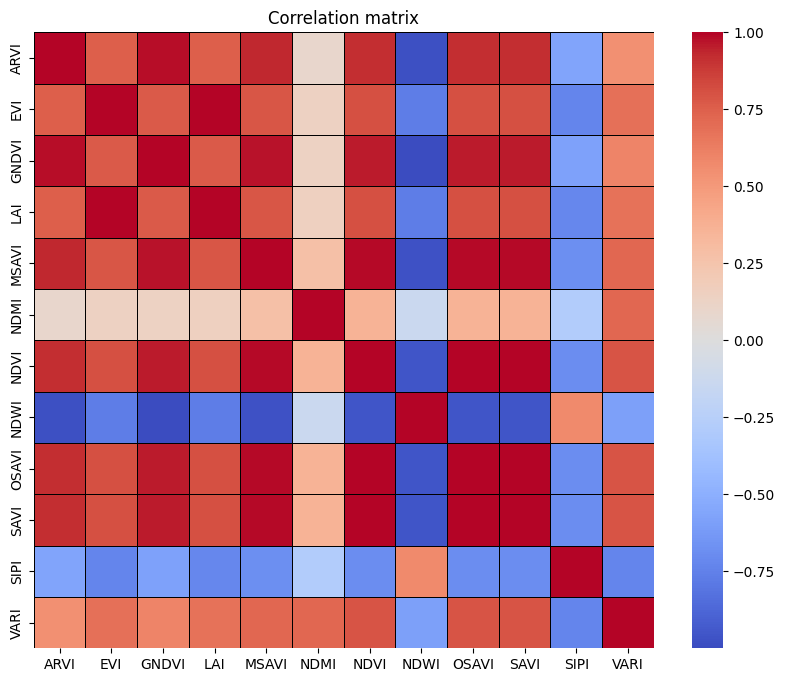

In [ ]:
# Afficher un heatmap de la matrice de corrélation avec une représentation de couleur
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation matrix')
plt.show()

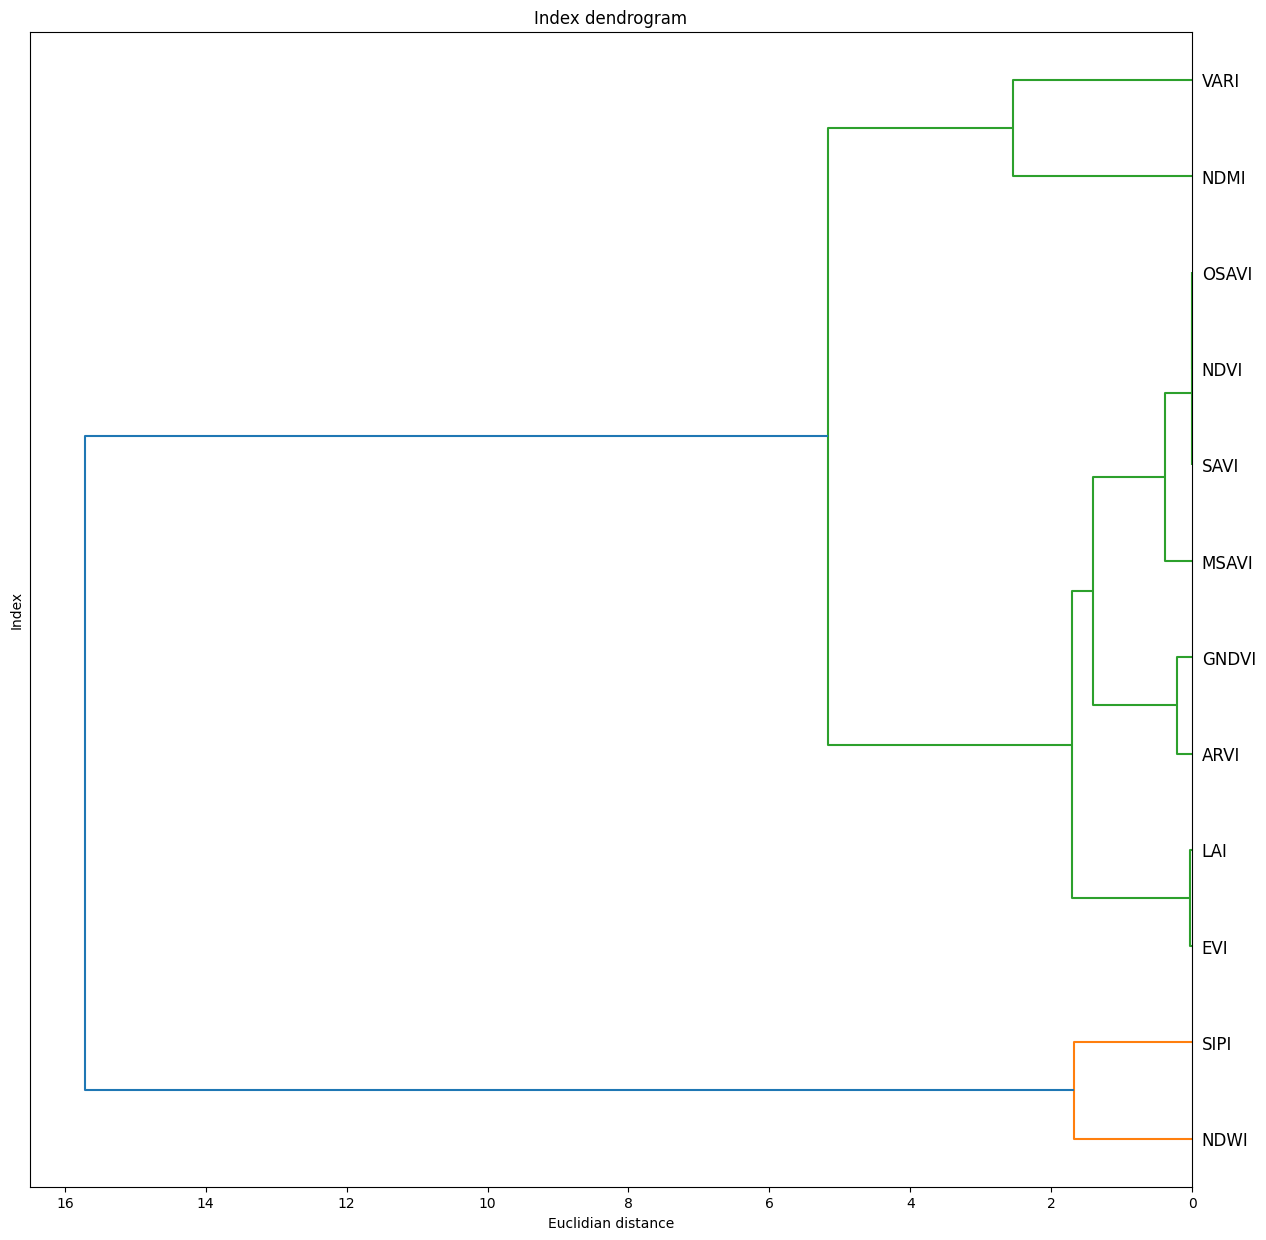

In [ ]:

# Tracer le dendrogramme
plt.figure(figsize=(15, 15))
dn = hierarchy.dendrogram(Z, labels=correlation_matrix.columns, orientation='left')
plt.title('Index dendrogram')
plt.xlabel('Euclidian distance')
plt.ylabel('Index')
plt.show()

In [ ]:
# Rassembler les indices en clusters avec une distance euclidienne inférieure à 10
clusters = hierarchy.fcluster(Z, t=0.5, criterion='distance')

# Créer un dictionnaire pour stocker les indices dans chaque cluster
clusters_indices = defaultdict(list)
for i, cluster in enumerate(clusters):
    clusters_indices[cluster].append(correlation_matrix.columns[i])

# Afficher les clusters avec leurs indices
for cluster, indices in clusters_indices.items():
    print(f"Cluster {cluster}: {indices}")

Cluster 4: ['ARVI', 'GNDVI']
Cluster 3: ['EVI', 'LAI']
Cluster 5: ['MSAVI', 'NDVI', 'OSAVI', 'SAVI']
Cluster 6: ['NDMI']
Cluster 1: ['NDWI']
Cluster 2: ['SIPI']
Cluster 7: ['VARI']


In [17]:
# Définir une fonction pour filtrer une collection par année
def filtrer_par_annee(collection, annee):
    return collection.filter(ee.Filter.calendarRange(annee, annee, 'year')).set({'year': annee})

# Définir une liste de noms de bandes à inclure
bands = ['NDVI']#, 'MSAVI', 'GNDVI', 'NDWI', 'NDMI', 'SAVI', 'OSAVI', 'ARVI', 'EVI', 'VARI', 'SIPI','LAI']

def calculer_image_mediane(collection,annee):
    # Calculer l'image médiane
    image_mediane = ee.Image(collection.select(bands).reduce(ee.Reducer.median()))
    # Ajouter la propriété 'year' à l'image médiane
    image_mediane = image_mediane.set({'year': annee})
    return image_mediane

# Créer une collection d'images médianes par année
s2_images_medianes_years = ee.ImageCollection(ee.List.sequence(2018, 2023).map(lambda annee: calculer_image_mediane(filtrer_par_annee(s2_col, annee),annee)))

display(s2_images_medianes_years)

In [18]:
bands = ['NDVI_median']#, 'MSAVI_median', 'GNDVI_median', 'NDWI_median', 'NDMI_median', 'SAVI_median', 'OSAVI_median', 'ARVI_median', 'EVI_median', 'VARI_median', 'SIPI_median','LAI_median']

def mean_index(image):
    mean = image.select(bands).reduceRegion(
        reducer = ee.Reducer.mean(),
        geometry = roi,
        scale = 10,
        maxPixels = 1e10
        )
    return ee.Feature(None, mean).set({'year':image.get('year')})

s2_time_series_years = s2_images_medianes_years.map(mean_index)


In [19]:
display(s2_time_series_years)

In [20]:
s2_time_series_years_df = ee.data.computeFeatures({
    'expression': s2_time_series_years,
    'fileFormat': 'PANDAS_DATAFRAME'
})

In [21]:
s2_time_series_years_df.head()

,geo,NDVI_median,year
0,None,0.385184,2018
1,None,0.350091,2019
2,None,0.488168,2020
3,None,0.578904,2021
4,None,0.343897,2022


In [22]:
s2_time_series_years_df.drop(columns = ['geo'],axis = 1, inplace = True )

In [23]:

# Centrer et réduire les données de chaque colonne, sauf 'date'
s2_time_series_years_df_normalized = s2_time_series_years_df.copy()
s2_time_series_years_df_normalized[bands] = s2_time_series_years_df[bands].apply(lambda x: (x - x.mean()) / x.std(), axis=0)

In [24]:

fig = px.line(s2_time_series_years_df, x="year", y=s2_time_series_years_df.columns,
              hover_data={"year": "|%Y"},
              title='NDVI median for each year: summer 2018 - 2022')

fig.update_xaxes(tickangle=90, dtick="M1", tickformat="%Y", tickfont=dict(family='Rockwell', color='black', size=12))
fig.update_layout(
    autosize=False,
    width=1200,
    height=600,
)
fig.show()
